In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler

import matplotlib.pyplot as plt
import numpy as np # Don't use this other than for matplotlib
from numpy import array
import copy
import datetime

In [2]:
batch_size = 32
image_width = 28
image_height = 28
code_size = 64
learning_rate = 0.0001
epochs = 20

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
     transforms.Normalize((0.5, ), (0.5, ))])

train_set = torchvision.datasets.FashionMNIST("./data", download=True,
                                              transform=transform)
indices = list(range(len(train_set)))
np.random.shuffle(indices)
train_after_split = SubsetRandomSampler(indices[:50000])
validation_after_split = SubsetRandomSampler(indices[50000:])

train_loader = torch.utils.data.DataLoader(train_set, sampler=train_after_split, batch_size=batch_size)
validation_loader = torch.utils.data.DataLoader(train_set, sampler=validation_after_split, batch_size=batch_size)


test_set = torchvision.datasets.FashionMNIST("./data", download=True, 
                                             train=False, transform=transform)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                         shuffle=False)

classes = ("T-shirt/Top", "Trouser", "Pullover", "Dress", "Coat",
           "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot")

Our image batch shape is torch.Size([4, 1, 28, 28])


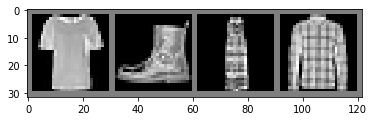

Shirt Ankle Boot Dress Shirt


In [4]:
def imshow(img):
    img = img / 2 + 0.5 # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = dataiter.next()
print("Our image batch shape is", images.size())
imshow(torchvision.utils.make_grid(images))

print(" ".join("%5s" % classes[labels[j]] for j in range(4)))

In [5]:
import random

# Noise is added by removing one or two quadrants of the image
# def noise_old(x):
#     #temp = x
#     for k in range(0,2):
#         #print("Iteration ", k)
#         x_offset = random.choice([0,14])
#         y_offset = random.choice([0,14])
#         #print("X: ", x_offset, " Y: ", y_offset)
#         for i in range(x_offset, x_offset+14):
#             for j in range(y_offset, y_offset+14):
#                 x[i][j] = 0
#     return x

# Noise added to a single image by "cutting" one or two quadrants randomly
def noise(x):
    x = array(x)                                # Convert image to numpy array
    middle = int(image_width/2)                 # Images are square
    for k in range(0,2):                        # Noise is applied twice - if the offset matches, 
        x_offset = random.choice([0,middle])    # only a single quadrant is changed
        for i in range(x_offset, x_offset+middle):
            # All values in the quadrant are set to zero
            x[x_offset:x_offset+middle,x_offset:x_offset+middle] = \
                torch.zeros(x[x_offset:x_offset+middle,x_offset:x_offset+middle].shape)   
    x = torch.from_numpy(x)                     # Converted back to tensor
    return x
            
# Apply noise to all images in a batch
def apply_noise(imgs):
    noisy_imgs = copy.deepcopy(imgs)
            
    for i in range(0, len(imgs)):
        noisy_imgs[i][0] = noise(imgs[i][0])    # Add random noise to image values

    imgs = imgs.view(imgs.size(0), -1)          # Reshape tensors to 1D array
    noisy_imgs = noisy_imgs.view(noisy_imgs.size(0), -1)
    
    return imgs, noisy_imgs

In [6]:
# Test noise function
# arr = [[1 for i in range(28)] for j in range(28)]
# arr2 = [[1 for i in range(28)] for j in range(28)]
# big = [arr, arr2]
# apply_noise(big)
# for x in big:
#     print(np.matrix(x))

In [7]:
# Autoencoder vanilla architecture
# One hidden layer compressing information
class Autoencoder(nn.Module):
    def __init__(self, code_size):
        super(Autoencoder, self).__init__()
        self.code_size = code_size
        self.encoder = nn.Linear(image_width*image_height, code_size)
        self.decoder = nn.Linear(code_size, image_width*image_height)
        
    def forward(self, input_x):
        encoded = torch.sigmoid(self.encoder(input_x))
        decoded = torch.sigmoid(self.decoder(encoded))
        return decoded

In [8]:
autoencoder = Autoencoder(code_size)
mse_loss = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)

In [9]:
def PSNR(original, compressed): 
    mse = torch.mean((original - compressed) ** 2)
    return 20 * torch.log10(255.0 / torch.sqrt(mse))

In [10]:
def train():
    train_loss_list = []         # To store loss for each epoch
    val_loss_list = []
    start_training_time = datetime.datetime.now()  #Timing training
    
    for epoch in range(epochs):
        train_loss = 0.0
        train_psnr = 0.0
        val_loss = 0.0
        val_psnr = 0.0
        
        for train_data in train_loader:                              # Iterate through training mini-batches
            train_imgs, _ = train_data                               # Labels for classification are ignored
            train_imgs, train_noisy_imgs = apply_noise(train_imgs)   # Noise is added to all images in a batch
            
            optimizer.zero_grad()                                    # Reset gradients 
            train_output = autoencoder(train_noisy_imgs)
            loss_func = mse_loss(train_output, train_imgs)           # Calculate MSE loss
            loss_func.backward()                                     # Backpropagation to update weights and bias
            optimizer.step()
            train_loss += loss_func.item()                           # Accumulated loss over all mini-batches
            #train_psnr += PSNR(train_imgs, train_noisy_imgs)
            
        train_loss = train_loss/len(train_loader)                    # Calculate mean MSE loss for an image
        #train_psnr = train_psnr/len(train_loader)
        train_loss_list.append(train_loss)
        print('Epoch: {} \tTraining Loss: {:.6f} \tTraining PSNR: {:.6f}'.format(
            epoch, 
            train_loss#,
            #train_psnr
            ))
            
        autoencoder.eval()                                           # Enter evaluation mode
        with torch.no_grad():                                        # Disable gradients computation
            for validation_data in validation_loader:                # Iterate through validation mini-batches
                val_imgs, _ = validation_data                        # Labels for classification are ignored
                val_imgs, val_noisy_imgs = apply_noise(val_imgs)     # Noise is added to all images in a batch
                
                val_output = autoencoder(val_noisy_imgs)
                loss_func = mse_loss(val_output, val_imgs)           # Calculate MSE loss
                val_loss += loss_func.item()                         # Accumulated loss over all mini-batches
                #val_psnr += PSNR(val_imgs, val_noisy_imgs)
        
            val_loss = val_loss/len(validation_loader)               # Calculate mean MSE loss for an image
            #val_psnr = val_psnr/len(validation_loader)
            val_loss_list.append(val_loss)
            print('Epoch: {} \tValidation Loss: {:.6f} \tValidation PSNR: {:.6f}'.format(
                epoch, 
                val_loss#,
                #val_psnr
                ))
        
    end_training_time = datetime.datetime.now()
    diff_training_time = end_training_time - start_training_time     #Calculate time elapsed
    print(diff_training_time)
    
    return train_loss_list, val_loss_list, epochs

In [11]:
train_loss, val_loss, epochs = train()

Epoch: 0 	Training Loss: 0.627785 	Training PSNR: 54.036434
Epoch: 0 	Validation Loss: 0.607015 	Validation PSNR: 54.077126
Epoch: 1 	Training Loss: 0.603252 	Training PSNR: 54.039974
Epoch: 1 	Validation Loss: 0.600017 	Validation PSNR: 54.055336
Epoch: 2 	Training Loss: 0.598226 	Training PSNR: 54.049332
Epoch: 2 	Validation Loss: 0.596573 	Validation PSNR: 54.065113
Epoch: 3 	Training Loss: 0.595480 	Training PSNR: 54.062115
Epoch: 3 	Validation Loss: 0.594404 	Validation PSNR: 54.023602
Epoch: 4 	Training Loss: 0.593734 	Training PSNR: 54.052067
Epoch: 4 	Validation Loss: 0.593025 	Validation PSNR: 54.059364
Epoch: 5 	Training Loss: 0.592500 	Training PSNR: 54.053612
Epoch: 5 	Validation Loss: 0.592049 	Validation PSNR: 54.059986
Epoch: 6 	Training Loss: 0.591545 	Training PSNR: 54.059471
Epoch: 6 	Validation Loss: 0.591273 	Validation PSNR: 54.066525
Epoch: 7 	Training Loss: 0.590797 	Training PSNR: 54.049915
Epoch: 7 	Validation Loss: 0.590545 	Validation PSNR: 54.034473
Epoch: 8

In [12]:
# Plot the MSE loss for all epochs
def loss_plot(loss_training, loss_type):
    if loss_type is "training":                # Type switches legend title
        plot_label = 'training set MSE loss'
    elif loss_type is "validation":
        plot_label = 'validation set MSE loss'
    plt.axis([0, epochs, min(loss_training), max(loss_training)])
    plt.plot(loss_training, label=plot_label)
    plt.legend(loc='upper right')

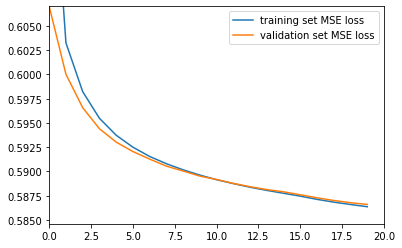

In [13]:
loss_plot(train_loss, "training")
loss_plot(val_loss, "validation")

In [16]:
def test():
    test_iter = iter(test_loader)
    for i in range(0,8):
        test_imgs, _ = test_iter.next()
        test_imgs, test_noisy_imgs = apply_noise(test_imgs)

        output = autoencoder(test_noisy_imgs)
        test_noisy_imgs = test_noisy_imgs.view(batch_size, 1, image_height, image_width)
        test_noisy_imgs = test_noisy_imgs.detach().numpy()
        output = output.view(batch_size, 1, image_height, image_width)
        output = output.detach().numpy()

        zipped_list = []
        columns = 4
        for i in range(0,batch_size-columns+1,columns):
            zipped_list.append(test_noisy_imgs[i:i+columns])
            zipped_list.append(output[i:i+columns])
        fig, axes = plt.subplots(nrows=int(2*batch_size/columns), ncols=columns, sharex=True, sharey=True, figsize=(10,5))
        for test_noisy_imgs, row in zip(zipped_list, axes):
            for img, ax in zip(test_noisy_imgs, row):
                ax.imshow(np.squeeze(img), cmap='gray')
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)

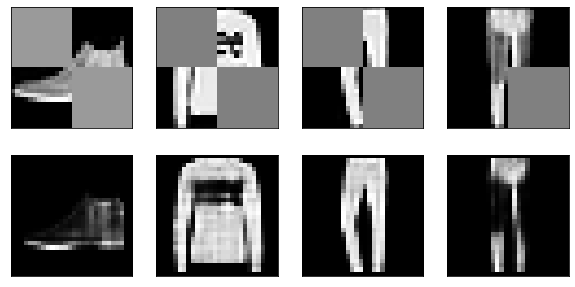

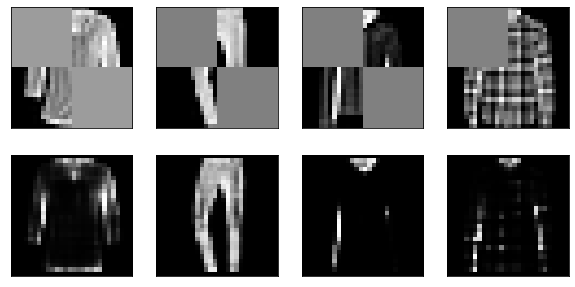

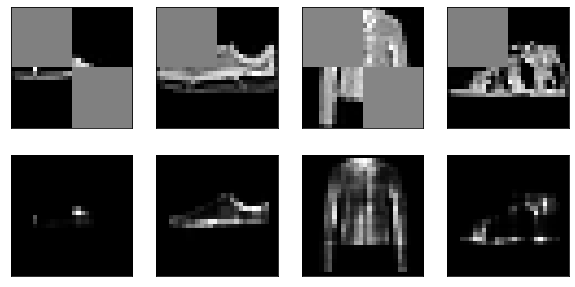

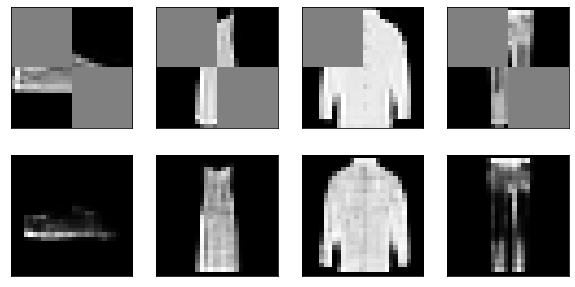

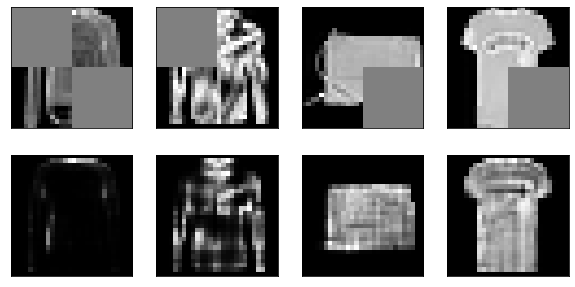

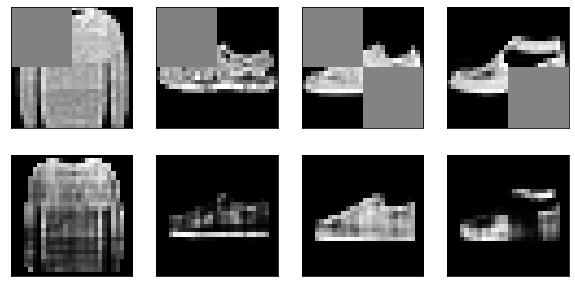

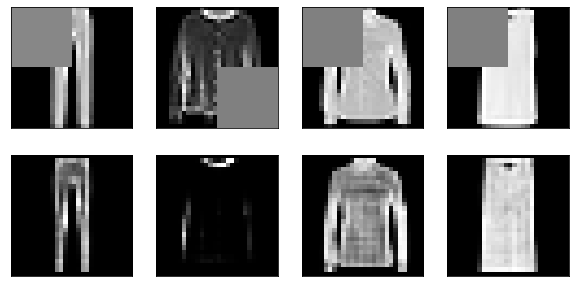

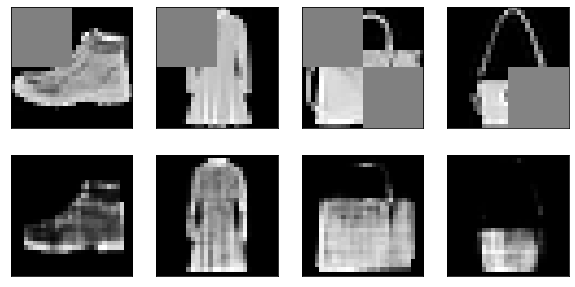

In [17]:
test()